# Particle Filter Experimental Results

This presents some of the results from the particle filter experiments. See [pf_experiments_plots.py](./pf_experiments_plots.py) for more results. This script mainly produces the graphs that are used in the accompanying paper.

## Initialisation

Read the requred libraries

In [2]:
%matplotlib inline

import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
#plt.ioff() # Turn off interactive mode
import pandas as pd
import warnings
from scipy.interpolate import griddata # For interpolating across irregularly spaced grid
import pickle # For saving computationally-expensive operations
import seaborn as sns
import pprint

# The following is to import the Particle Filter code
# (mostly we just read results that were created previously, but sometimes it's  useful to
# visualise additional experiments).
import sys
sys.path.append('../../stationsim')
sys.path.append('../..')
from stationsim.particle_filter import ParticleFilter
from stationsim.stationsim_model import Model
import time
import multiprocessing

Configure the script

In [3]:
# We need to tell the script which directory the results are in

# First try to get the directory of this .ipynb file
#root_dir = !echo %cd% # this might work under windows
root_dir = !pwd # under linux/mac # This works in linux/mac

# Now append the specific directory with results:
path = os.path.join(root_dir[0], "results","4/noise0.25")
print(f"Plotting results in directory: {path}")

# Need to set the number of particles and agents used in the experiments. These are set in the file that runs
# the experiments: ./run_pf.py
# Copy the lines near the top that set the number of particles and agents

# Lists of particles, agent numbers, and particle noise levels
#num_par = list ( [1] + list(range(10, 50, 10)) + list(range(100, 501, 100)) + list(range(1000, 2001, 500)) + [3000, 5000, 7500, 10000])
#num_age = [2, 5, 10, 15, 20, 30, 40, 50]
num_par = [1, 10, 50, 100, 500, 1000, 2000, 3000, 5000, 7500, 10000]
#num_age = [2, 10, 20, 30, 40, 50]
num_age = [2, 10, 20, 30, 40] # Have run experiments with 50 agents, but insufficient particles, so don't include

# Use log on y axis?
uselog = True

# Font sizes for figures. These match those in pf_experiments_plots.ipynb
# (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title (when using axes)

Plotting results in directory: /localhome/earpte/GitHub/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.25


##  StationSim Diagnostics

Before analysing the results of the particle filter, do some diagnostics of the model itself.

Same model parameters as those used in the particle filter experiments.

In [4]:
model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 100, # Important: number of agents.
    'speed_min': .1,
    'separation': 2,
    'do_history': True, # Keeps track of diagnostic information about the model instance
    'do_print': True, # Print information about the run to the console
}

### Collision Graph

The number of colisions directly influences the amount of randomness in the model. This is because each time an agent collides with another it makes a random decision about whether to try to go round it to the right or the left. With no colisions then the model is deterministic.

Repeatedly run a model, varying the number of agents from 1 to 50, and count the number of wiggles. Do this using multiprocess.Pool so that it is quick.

In [5]:
# A list of number of agents for the model to run.
# Repeat the list 10 times because the wiggle ount will vary slightly on each run
agents = list(range(1,101, 5)) * 20
params = [model_params] * len(agents)

numcores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=numcores)

# This is a workaround to allow multiprocessing.Pool to work 
# The function (called counts_wiggles) that is called by pool.starmap runs the model with a 
# given number of agents needs to be defined  in a separate .py file (f.py) and imported.
# https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397
import f

# Check it works.
f.count_wiggles(10, model_params)

(10, 11)

Run the models:

In [5]:
agents_wiggles = None
try:
    agents_wiggles = pool.starmap(f.count_wiggles, list(zip(agents, params)))

finally: # Make sure all the threads are closed
    pool.close()

agents_wiggles = np.array(agents_wiggles)

Now draw a graph of wiggles v.s. agents

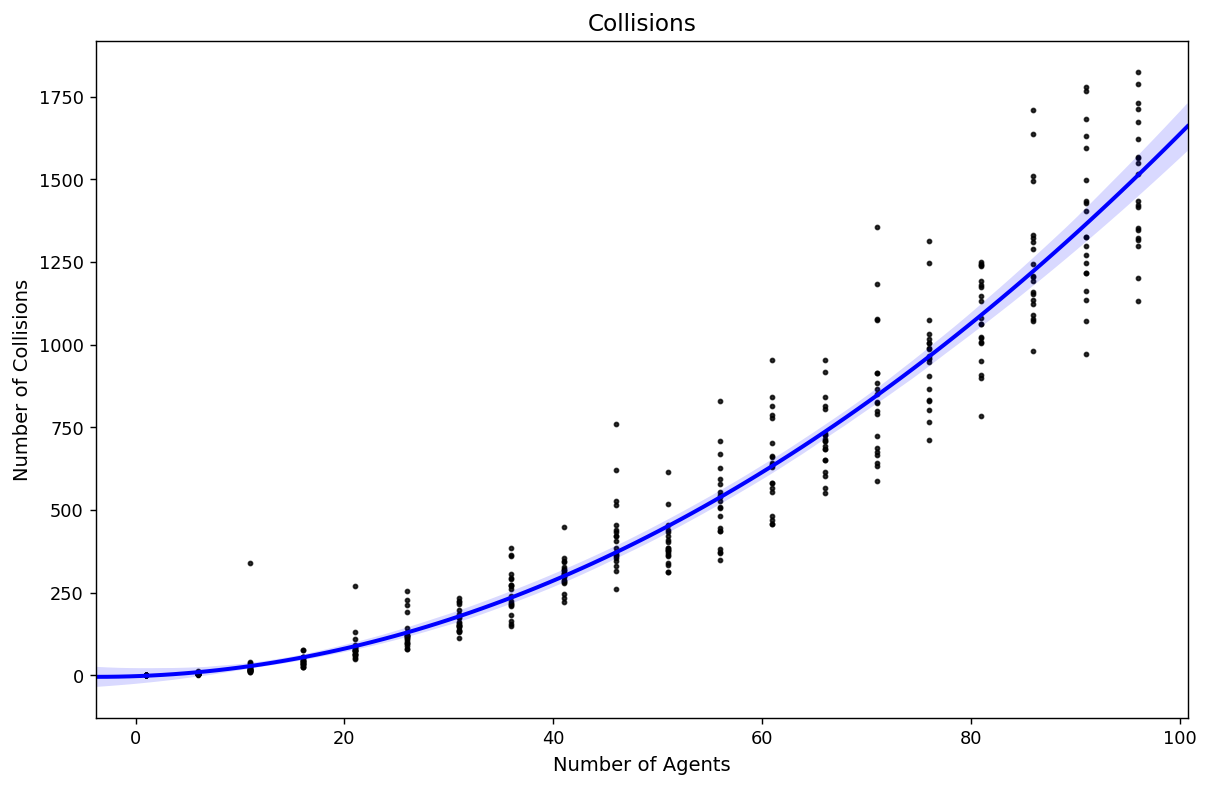

In [6]:
# Create a figure and an axis
fig, ax = plt.subplots(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')

# Use seaborn to add a plot to the axis
sns.regplot(ax=ax, x=agents_wiggles[:,0], y=agents_wiggles[:,1], 
                 order = 2, ci=99,
                 scatter_kws={"color":"black", "s":5}, 
                 line_kws={"color":"blue"})

ax.set_title("Collisions")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Number of Collisions")

plt.savefig("figs_for_pf_paper/wiggle_count.png", bbox_inches="tight")

### Crowding

Show where the collisions are happenning

To begin, create a new model and run it:

In [4]:
model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 100, # Important: number of agents.
    'speed_min': .1,
    'separation': 2,
    'do_history': True, # Keeps track of diagnostic information about the model instance
    'do_print': True, # Print information about the run to the console
}
model = Model(**model_params) # Create a model instance
# Run the model for the default number of iterations
for _ in range(model.step_limit):
    model.step()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
	Iteration: 1100/3600
	Iteration: 1200/3600
	Iteration: 1300/3600
	Iteration: 1400/3600
	Iteration: 1500/3600
StationSim None - Everyone made it!


#### Agent trails (paths)

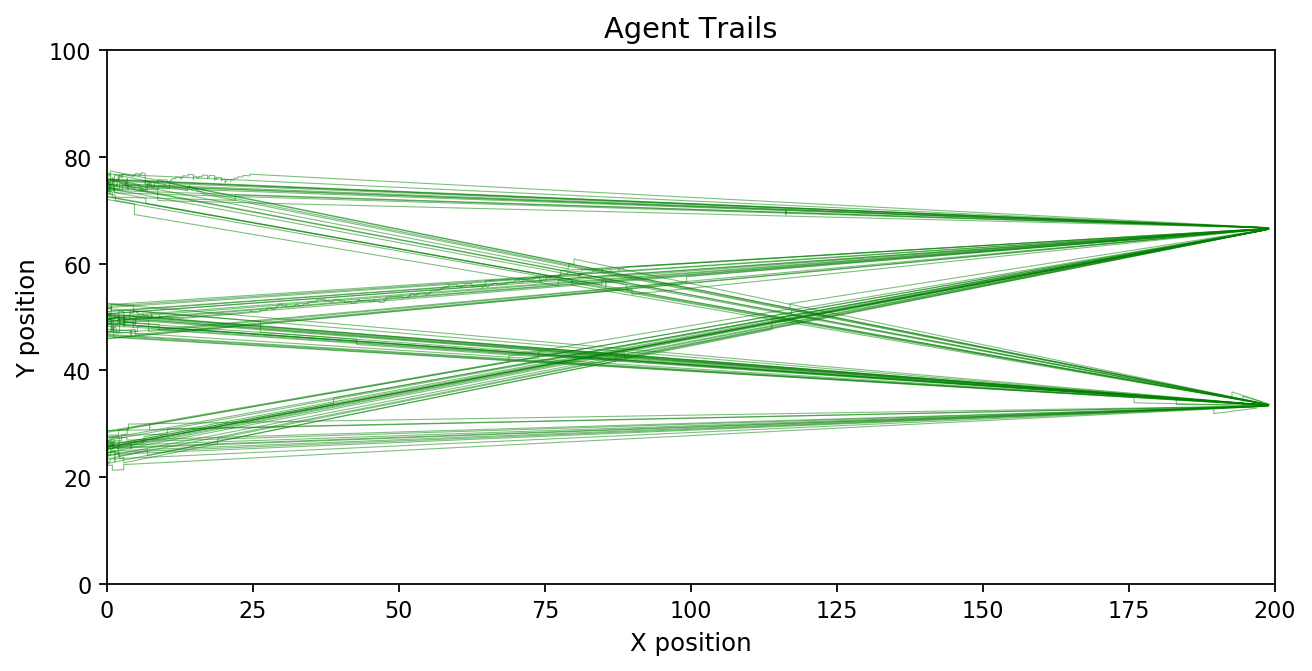

In [12]:
fig = model.get_trails(plot_axis=True, plot_legend=False)
#fig.savefig("figs_for_pf_paper/crowding-trails.png", bbox_inches="tight")

#### Population density

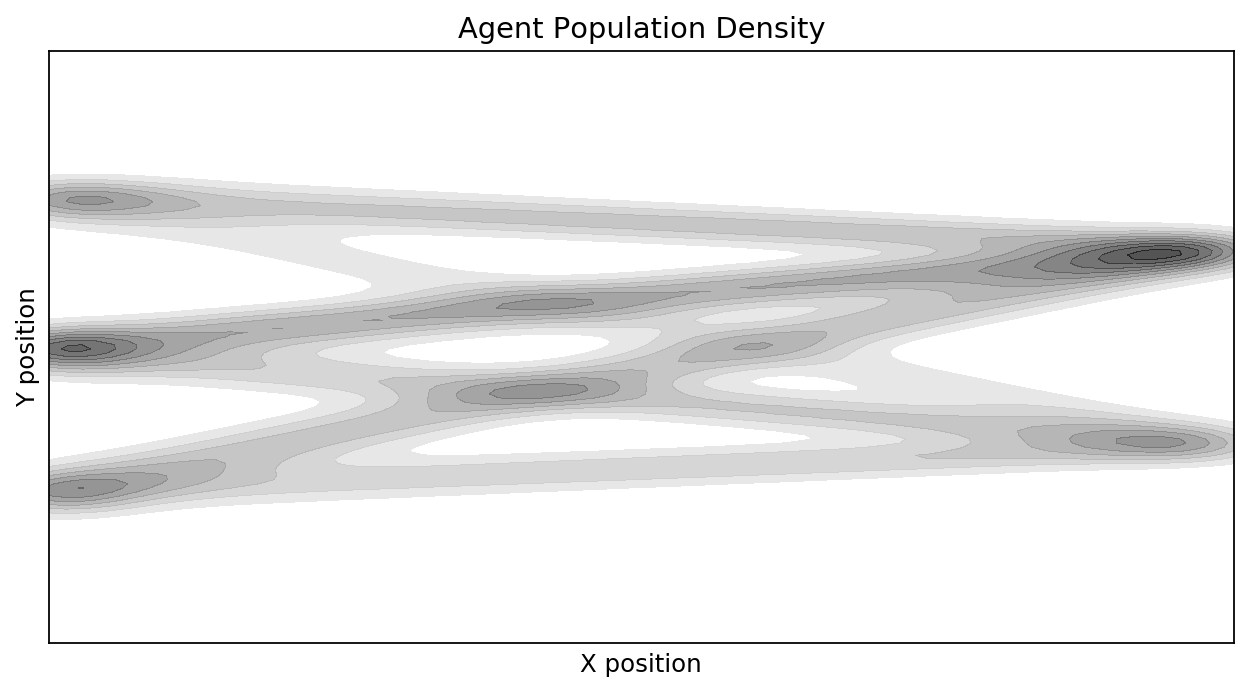

In [13]:
fig = model.get_location_map(title="Agent Population Density", plot_axis=True, color_bar=False)
# fig = model.get_location_map(do_kdeplot=False) # (non-kde version)

# fig.savefig(f'{id}_location_map_fast.png')
#fig.savefig("figs_for_pf_paper/crowding-density.png", bbox_inches="tight")

#### Collision map (_not currently used in the paper_).

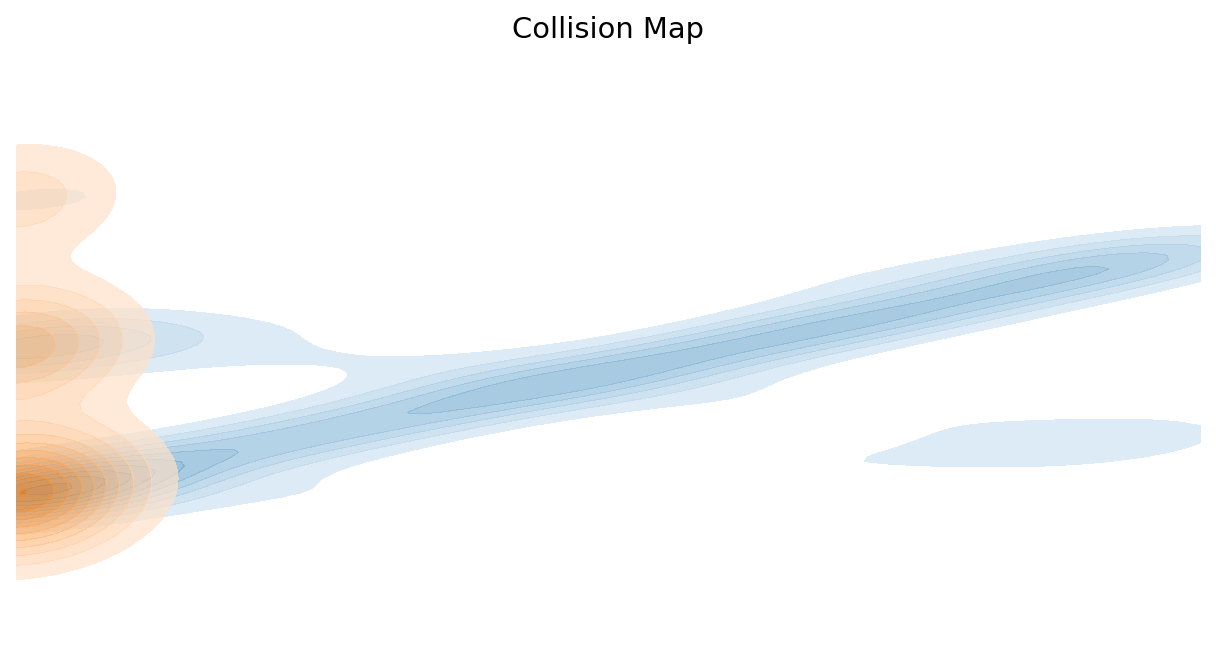

In [25]:
fig = model.get_collision_map()

#### Video (_not used in paper_)

In [ ]:
from IPython.display import HTML

ani = model.get_ani(show_separation=True)
HTML(ani.to_html5_video()) # So that we can see it in the notebook
#ani.save(f'stationsim_{id}_ani.mp4') # Save the file

### Other analytics

#### Statistics about the model evolution

In [7]:
pp = pprint.PrettyPrinter(indent=4) # For printing nicely

analytics = model.get_analytics()

pp.pprint(analytics)
# print(analytics, file=open(f'{id}_stats.txt','w'))

{   'Active': 0,
    'Finish Time': 1593,
    'Finished': 100,
    'Mean Collisions': 95.49,
    'Mean Time Delay': 29.547354868530576,
    'Mean Time Expected': 257.2626451314694,
    'Mean Time Taken': 286.81,
    'Mean Wiggles': 17.4,
    'Total': 100}


#### Histogram of times taken

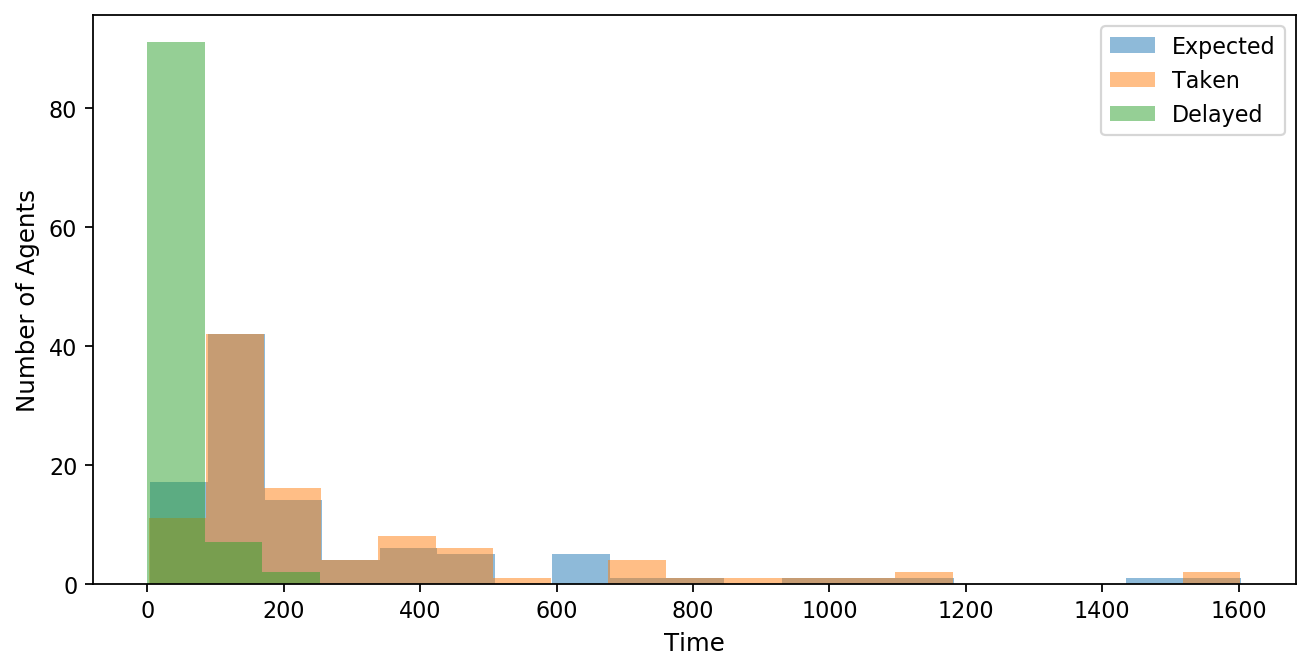

In [11]:
fig = model.get_histogram()
# fig.savefig(f'{id}_histogram.png')

### New graphs for the AAMAS paper

In [34]:
model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 40, # Important: number of agents.
    'speed_min': .1,
    'separation': 2,
    'do_history': True, # Keeps track of diagnostic information about the model instance
    'do_print': True, # Print information about the run to the console
}
model1 = Model(**model_params) # Create a model instance
# Run the model for the default number of iterations
for _ in range(model1.step_limit):
    model1.step()
    
model2 = Model(**model_params) # Create a model instance
# Run the model for the default number of iterations
for _ in range(model2.step_limit):
    model2.step()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
StationSim None - Everyone made it!
	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
	Iteration: 1100/3600
	Iteration: 1200/3600
	Iteration: 1300/3600
	Iteration: 1400/3600
	Iteration: 1500/3600
	Iteration: 1600/3600
	Iteration: 1700/3600
StationSim None - Everyone made it!


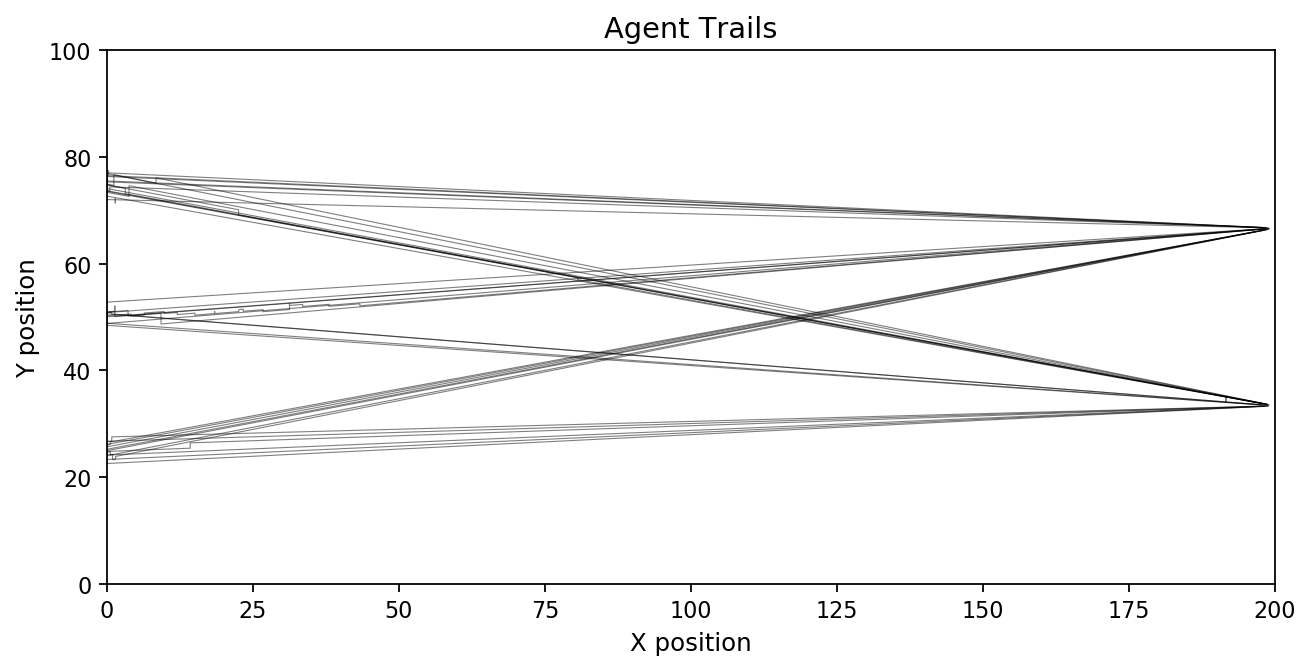

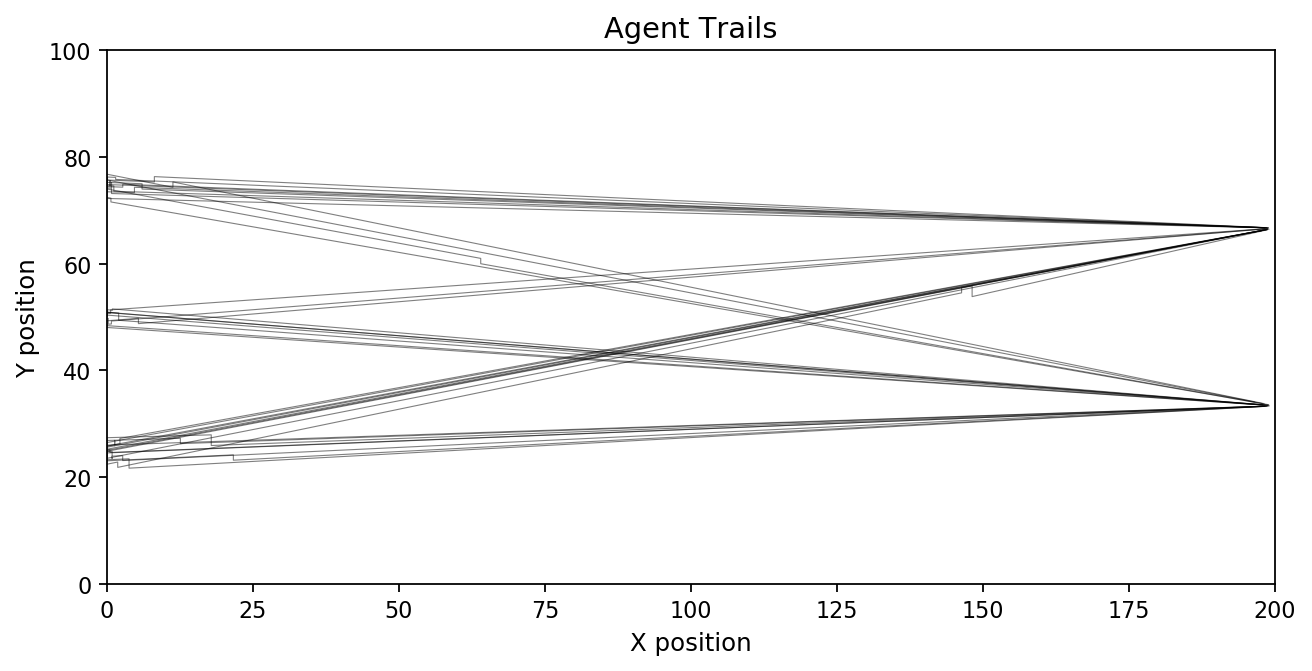

In [35]:
fig1 = model1.get_trails(plot_axis=True, plot_legend=False, colours=('gray','black','red'))#, xlim=(0,100), ylim=(20,80))
#fig1.savefig("figs_for_pf_paper/crowding-trails-AAMAS-1.png", bbox_inches="tight")

fig2 = model2.get_trails(plot_axis=True, plot_legend=False, colours=('gray','black','red'))#, xlim=(0,100), ylim=(20,80))
#fig2.savefig("figs_for_pf_paper/crowding-trails-AAMAS-2.png", bbox_inches="tight")

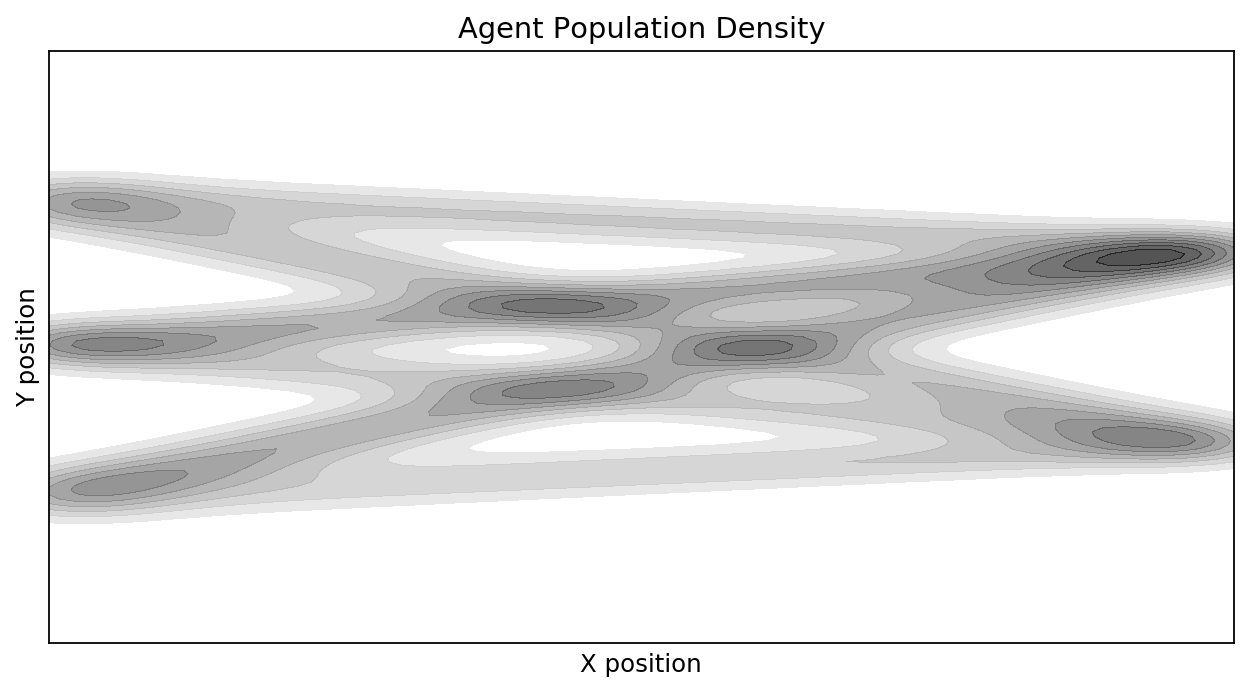

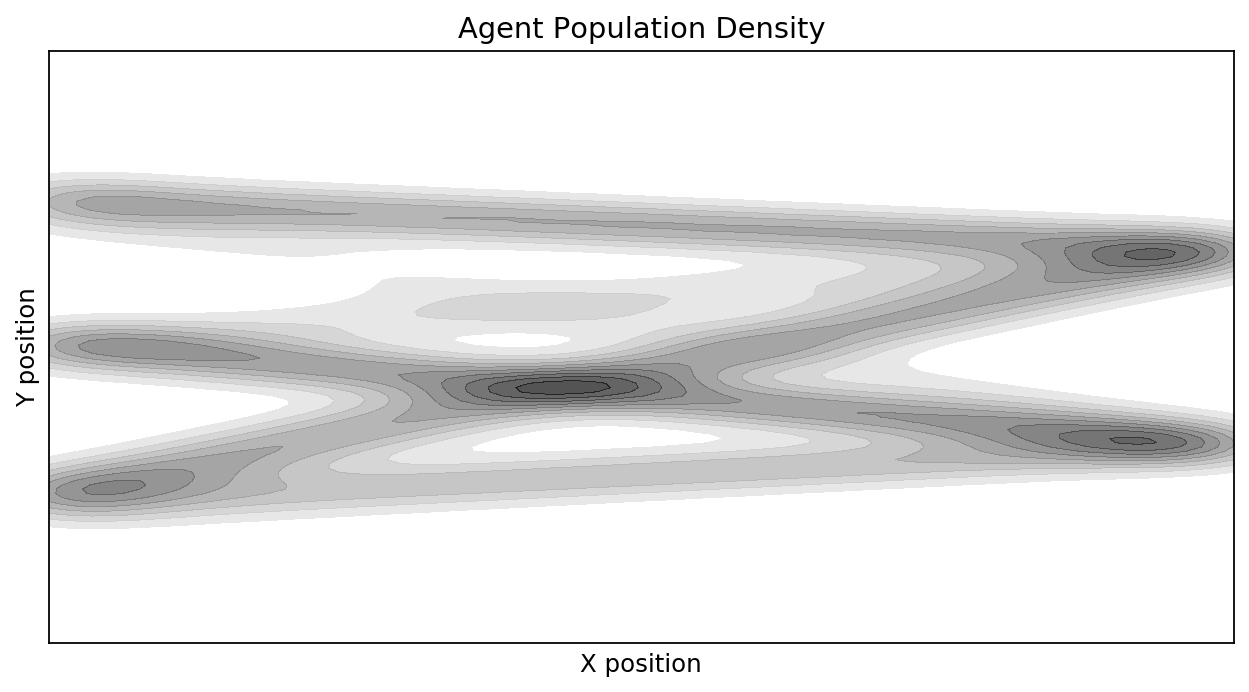

In [36]:
fig1 = model1.get_location_map(title="Agent Population Density", plot_axis=True, color_bar=False)
#fig1.savefig("figs_for_pf_paper/crowding-density-AAMAS-1.png", bbox_inches="tight")

fig2 = model2.get_location_map(title="Agent Population Density", plot_axis=True, color_bar=False)
#fig2.savefig("figs_for_pf_paper/crowding-density-AAMAS-2.png", bbox_inches="tight")

And produce a screenshot of the running model. (_Note that I actually take a picture of one frame of this and use that in the paper, not the whole video_).

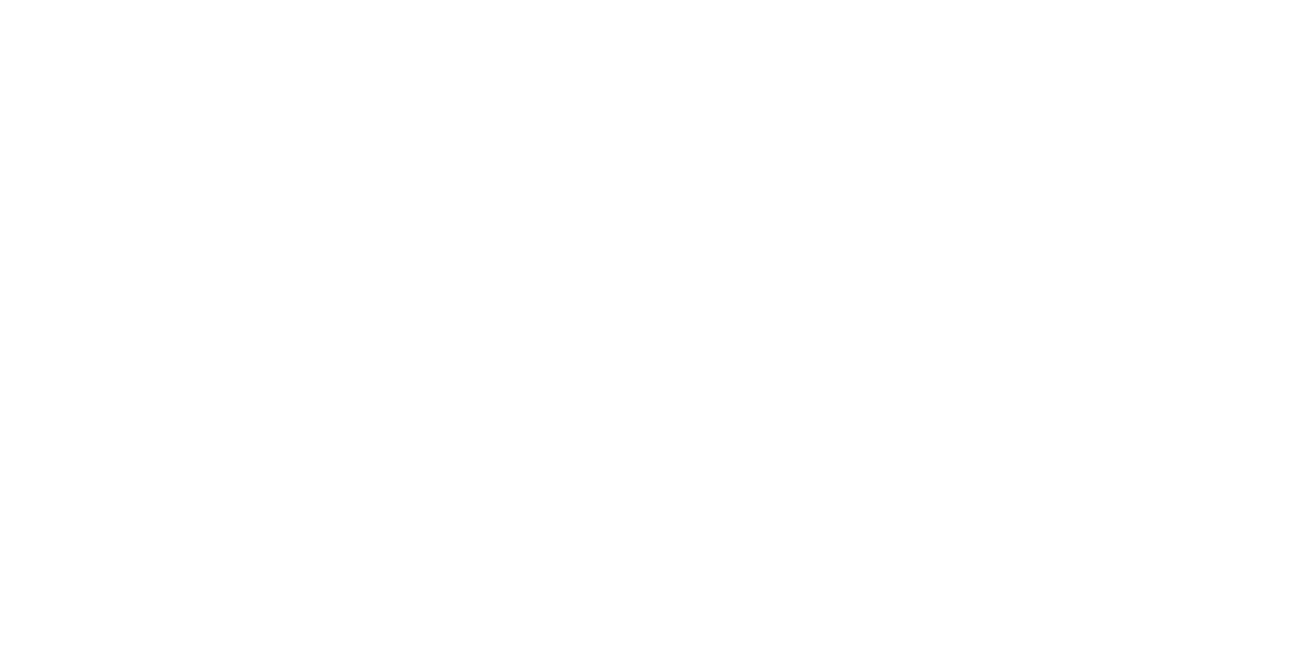

In [41]:
ani = model1.get_ani(show_separation=True)  # slow
ani.save("figs_for_pf_paper/model_video.mp4")

### New graph for the ECAI paper

In [7]:
model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 100, # Important: number of agents.
    'speed_min': .1,
    'separation': 2,
    'do_history': True, # Keeps track of diagnostic information about the model instance
    'do_print': True, # Print information about the run to the console
}
ecai_model = Model(**model_params) # Create a model instance
# Run the model for the default number of iterations
for _ in range(model1.step_limit):
    ecai_model.step()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
	Iteration: 600/3600
	Iteration: 700/3600
	Iteration: 800/3600
	Iteration: 900/3600
	Iteration: 1000/3600
	Iteration: 1100/3600
	Iteration: 1200/3600
	Iteration: 1300/3600
	Iteration: 1400/3600
	Iteration: 1500/3600
	Iteration: 1600/3600
StationSim None - Everyone made it!


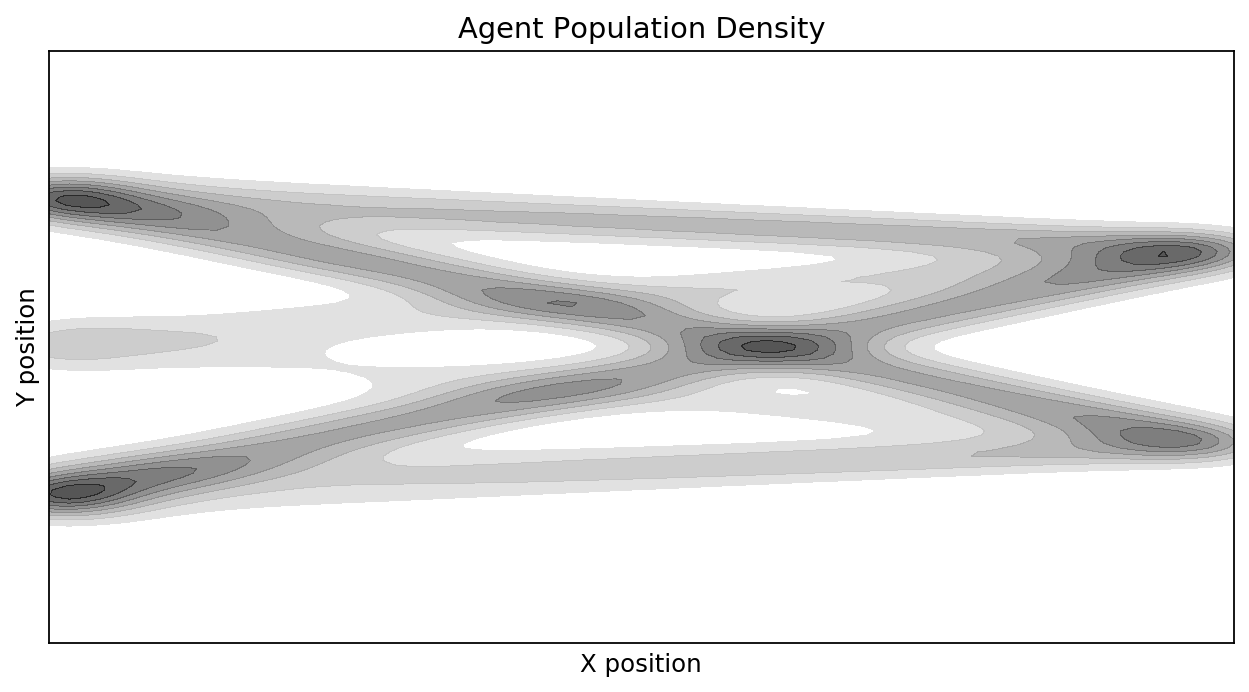

In [9]:
ecai_fig = ecai_model.get_location_map(title="Agent Population Density", plot_axis=True, color_bar=False)
ecai_fig .savefig("figs_for_pf_paper/crowding-density-ECAI.png", bbox_inches="tight")

## Particle Filter Results

Now start producing the results of the particle filter experiments

### Read the data

In [12]:
# From now on refer to the lists of agents and particles using different names (TODO: refactor)
particles = num_par
agents = num_age


if not os.path.isdir(path):
    sys.exit("Directory '{}' does not exist".format(path))


def is_duplicate(fname, files):
    """
    Sees if `fname` already exists in the `duplicates` list. Needs to strip off the integers at the end of
    the file (these were added by the Particle Filter script to prevent overridding experiments).
    :param fname:
    :param duplicates:
    :return: True if this file exists already, false otherwise
    """
    regex = re.compile(r"(.*?)-\d*\.csv") # Find everthing before the numbers at the end of the filename
    fname_stripped = re.findall(regex, fname)[0]
    for f in files:
        if re.findall(regex, f)[0] == fname_stripped:
            return True # There is a duplicate
    return False # No duplicates found


files = []
duplicates = [] # List of diplicate files
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            fname = os.path.join(r, file)
            if is_duplicate(fname, files):
                duplicates.append(fname)
            else:
                files.append(fname)

if len(files) == 0:
    sys.exit("Found no files in {}, can't continue".format(path) )
elif len(duplicates) > 0:
    warnings.warn("Found {} duplicate files:\n\t{}".format(len(duplicates), "\n\t".join(duplicates)))
else:
    print("Found {} files".format(len(files)))


# Errors are a matrix of particles * agents. These are a tuple because the errors
# are calculated before and after resampling

def init_matrix():
    return ( np.zeros(shape=(len(particles),len(agents))), np.zeros(shape=(len(particles),len(agents))) )

min_mean_err = init_matrix()
max_mean_err = init_matrix()
ave_mean_err = init_matrix() # Mean of the mean errors
med_mean_err = init_matrix() # Median of the mean errors
min_abs_err  = init_matrix()
max_abs_err  = init_matrix()
ave_abs_err  = init_matrix() # Mean of the mean errors
med_abs_err  = init_matrix() # Median of the mean errors
min_var      = init_matrix()
max_var      = init_matrix()
ave_var      = init_matrix()
med_var      = init_matrix()

# Regular expressions to find the particle number and population total from json-formatted info at the start of the file
particle_num_re = re.compile(r".*?'number_of_particles': (\d*).*?")
agent_num_re = re.compile(r".*?'pop_total': (\d*).*?")

print(f"Reading files in {path}....",)
data_shape = None # Check each file has a consistent shape
warn_about_arrays = False # To stop a warning (see below) being printed more than once
for i, f in enumerate(files):

    file = open(f,"r").read()
    #data = pd.read_csv(f, header = 2).replace('on',np.nan)
    data = pd.read_csv(f, header=2).replace('on', np.nan)
    # Check that each file has a consistent shape
    if i==0:
        data_shape=data.shape
    if data.shape != data_shape:
        # If the columns are the same and there are only a few (20%) rows missing then just continue
        if ( data_shape[1] == data.shape[1] ) and ( data.shape[0] > int(data_shape[0] - data_shape[0]*0.2) ):
            warnings.warn("Current file shape ({}) does not match the previous one ({}). Current file is: \n\t{}. \n\tLess than 20% rows missing so continuing".format(
                                  str(data.shape), str(data_shape), f ))
        # Can exit if the shapes are too bad (ignoring this for now)
        #else:
        #    sys.exit("Current file shape ({}) does not match the previous one ({}). Current file is: \n\t{}. \n\tNot continuing".format(
        #            str(data.shape), str(data_shape), f  ))

    # Find the particle number and population total from json-formatted info at the start of the file
    search = re.findall(particle_num_re, file)
    try:
        particle_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of particles in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
    search = re.findall(agent_num_re, file)
    try:
        agent_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of agents in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
        
    # Calculate the statstics before and after resampling
    for before in [0,1]:
        d = data[ data.loc[:,'Before_resample?'] == before] # Filter data
        
        try:

            data_mean =  d.mean() # Calculate the mean of all columns
            data_median = d.median() # and also sometimes use median

            min_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Mean_errors']
            max_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Mean_errors']
            ave_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_mean_errors']
            med_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_mean_errors']
            min_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Absolute_errors']
            max_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Absolute_errors']
            ave_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_Absolute_errors']
            med_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_Absolute_errors']
            min_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_variances']
            max_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_variances']
            ave_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_variances']
            med_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_variances']
        except ValueError:
            if not warn_about_arrays:
                warnings.warn(f"Have found a file ({f}) whose number of agents ({agent_num}) and/or particles ({particle_num}) don't fit into the results arrays. Have you defined num_age and num_par correctly? (Further warnings surpressed)")
            warn_about_arrays = True
        
# There will never be zero error, so replace 0s with NA
data[data == 0] = np.nan        

print("...finished reading {} files".format(len(files)))

Found 67 files
Reading files in /Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.25....


/Users/nick/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Have found a file (/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.25/pf_particles_10000_agents_50_noise_0.25-1567851692.csv) whose number of agents (50) and/or particles (10000) don't fit into the results arrays. Have you defined num_age and num_par correctly? (Further warnings surpressed)
/Users/nick/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Current file shape ((38, 10)) does not match the previous one ((40, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.25/pf_particles_100_agents_2_noise_0.25-1567805919.csv. 
	Less than 20% rows missing so continuing
/Users/nick/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Current file shape ((38, 10)) does not match the previous one ((40, 10)). Current file is: 
	/Users/nick/gp/d

...finished reading 67 files


Sanity check:

In [13]:
# Max error after resampling should be less than before resampling
print(f"Max errors (mean) (before/after): {max_mean_err[0].max()} / {max_mean_err[1].max()}")
assert max_mean_err[1].max() <= max_mean_err[0].max() 
# Min error should not have gone up
print(f"Min errors (before/after): {min_mean_err[0].max()} / {min_mean_err[1].max()}")
assert min_mean_err[1].max() <= min_mean_err[0].max()
# Average errors should mostly have gone down (wont always happen due to addition of particle noise)
false_count = 0
total = 0
for b,a in zip(ave_mean_err[0], ave_mean_err[1]):
    total += len(b)
    for i in range(len(b)):
        if b[i] < a[i]:
            false_count += 1
print(f"In {false_count} / {total} experiments resampling *increased* the mean error")

Max errors (mean) (before/after): 122.33230114709875 / 122.33230114709875
Min errors (before/after): 2.150052489655594 / 1.134972293697824
In 8 / 55 experiments resampling *increased* the mean error


### Sampling locations

Because the experiments are distributed across the agents/particles parameter space we need to create a grid and interpolate to show how the error varies

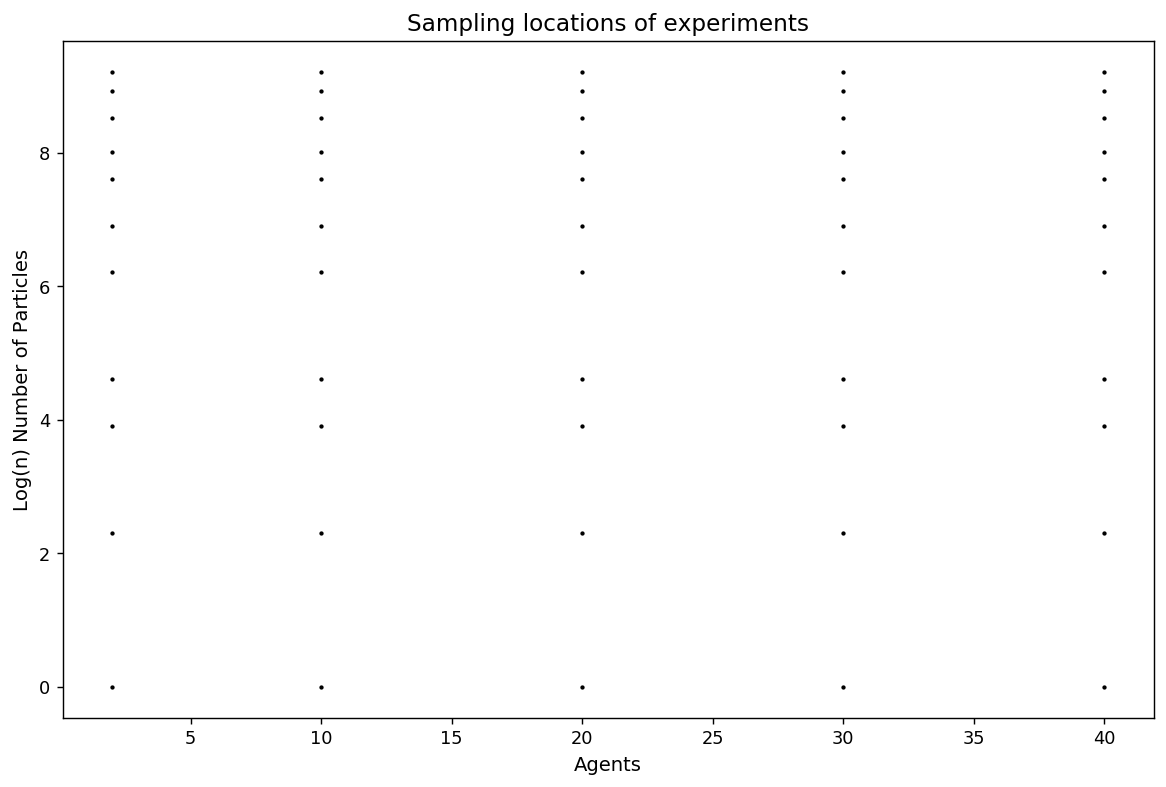

In [14]:
# First plot all of the locations in the grids for which we have data (these are
# not necessarily evenly spaced).
# See here for instructions on how to do heatmap with irregularly spaced data:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_Gridding_irregularly_spaced_data.html

fig, ax = plt.subplots(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')

# Define the grid.
# First need the points that the observations are taken at
x, y = [], []
for i in range(len(agents)):
    for j in range(len(particles)):
        x.append(agents[i])
        if uselog:
            y.append(np.log(particles[j]))
        else:
            y.append(particles[j])
x = np.array(x)
y = np.array(y)

# Now the grid to interpolate over (used later)
xi = np.linspace(0,max(agents)   ,100)
yi = None
if uselog:
    yi = np.geomspace(0.01,np.log(max(particles)),100)
else:
    yi = np.linspace(0,max(particles),100)

# Plot the point locations
ax.scatter(x=x, y=y, marker='o',c='black',s=2)
ax.set_xlabel('Agents')
ax.set_ylabel('Log(n) Number of Particles' if uselog else 'Number of Particles')
ax.set_title("Sampling locations of experiments")

fig.savefig("figs_for_pf_paper/sampling_locations.png", bbox_inches="tight")

Also need plot definitions so it is easy to extract the required data

In [15]:
# Define the plots so that they can be plotted in a loop
plot_def = {
    "Min absolute error" : min_mean_err,
    "Max absolute error" : max_mean_err,
    "Avg absolute error" : ave_mean_err,
    "Median mean error":  med_mean_err,
    "Min absolute error"  : min_abs_err,
    "Max absolute error"  : max_abs_err,
    "Avg absolute error"  : ave_abs_err,
    "Median absolute error": med_abs_err,
    "Min variance"   : min_var,
    "Max variance"   : max_var,
    "Avg variance"  : ave_var,
    "Median variance"  : med_var
    }

And some functions / other parameters that are consistent across all plots:

In [16]:
# Some things that are consistent across all the plots
_xlabel = 'Number of Agents'
_ylabel = lambda x: 'Log(n) Number of Particles' if x else 'Number of Particles'

# Colours to use in the colour bars. See the different ones available at:
# https://matplotlib.org/examples/color/colormaps_reference.html
#colour_map = plt.cm.binary # black -> white
colour_map = plt.cm.bone # black -> white (with a bit of blue)
#colour_map = plt.cm.ocean # green -> blue (dark)
#colour_map = plt.cm.jet # blue -> green -> red

# Type of interpolation i.e. 'nearest' of 'linear' (see help(griddata)))
#interpolate_method = "nearest"
interpolate_method = "linear"

# Number of colours
num_colours = 50

def make_z(d):
    """Calculate the value of the statistic being visualised (e.g. mean_error) as a long list"""
    z = []
    for i in range(len(agents)):
        for j in range(len(particles)):
            z.append(d[j,i])
    assert len(x) == len(y) and len(x) == len(z)
    return np.array(z)

def make_zi(z):
    """Grid the data"""
    return griddata(points=(x, y),
              values=z,
              xi=(xi[None,:], yi[:,None]),
              method=interpolate_method)

### Headline Plot: Median error after resampling


The headline: how the error changes with number of particles v.s. number of agents.

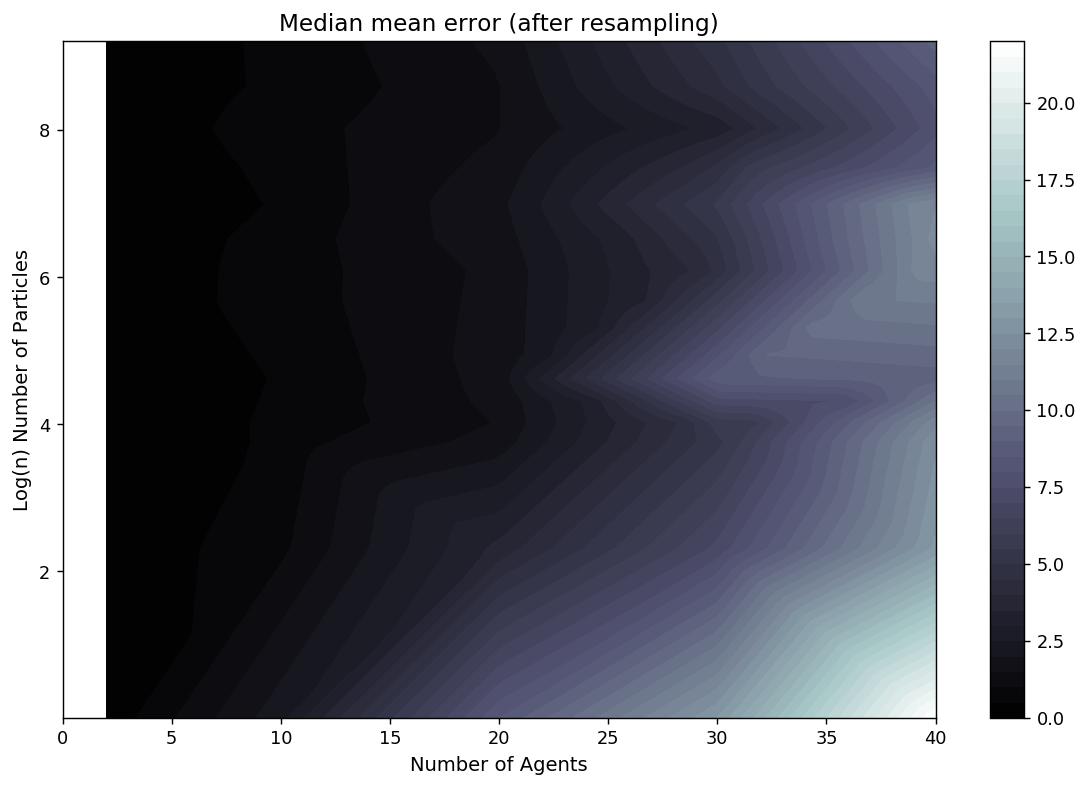

In [39]:
# Title and array
#title = "Median absolute error"
title = "Median mean error"
#title = "Avg absolute error"
#title = "Median variance"
d = plot_def[title][1] # Index 1 for the array created *after* resampling

# Sanity check: the shape of the array should be matrix of numer of particles per experement
# agents number of agents per experiment
d.shape == (len(particles),len(agents))

# Make a pandas data frame for use in benchmarking later (basically remember the values in this plot)
headline_results= pd.DataFrame(d, 
                               columns=[str(a)+" agents" for a in agents], 
                               index=[str(p)+" particles" for p in particles])

# Calculate the value of the error statistic as a long list
z = make_z(d)

# Turn that into a grid
zi = make_zi(z)

fig = plt.figure(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
# cs1 = plt.contour( xi,yi,zi,8,linewidths=0.5,colors='k') # Lines around contours
cs2 = plt.contourf(xi,yi,zi,levels=num_colours,cmap=colour_map)
plt.colorbar() # draw colorbar
#plt.scatter(x,y,marker='o',c=[cs2.get_cmap()(val) for val in z], s=2)
#plt.scatter(x,y,marker='o',c=z, cmap=cs2.get_cmap(), s=10, edgecolors="white")
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
#if uselog:
#    plt.ylim(2,9)
# Make the numbers not logged
#locs, labels = plt.yticks() # So that numbers are not logged 
#plt.yticks(locs, [math.exp(int(x.get_text())) if int(x.get_text().replace("'",'')) > 0 else '' for x in labels]) 
plt.title(title+" (after resampling)")
#plt.show()
plt.savefig("figs_for_pf_paper/median_abs_error.png", bbox_inches="tight")
del(z,zi) # tidy up
#del(z, d, zi) # tidy up

## Visualising Individual PF instances

What does that error actually mean in practice? Take a snaphsot of a high- and low- error PF implementation while it's running to give an idea about how close it gets to the 'real' system

In [14]:
# These are the basic parameter settings required. 
# We will chance the number of particles and agents to see what the experiments are like

model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 10, # IMPORTANT: number of agents
    'speed_min': .1,
    'separation': 2,
    'batch_iterations': 4000,  # Only relevant in batch() mode
    'do_history': False,
    'do_print': False,
}
# Model(model_params).batch() # Runs the model as normal (one run)

filter_params = {
    'number_of_particles': 10, #IMPORTANT: number of particles
    'number_of_runs': 1,  # Number of times to run each particle filter configuration
    'resample_window': 100,
    'multi_step': True,  # Whether to predict() repeatedly until the sampling window is reached
    'particle_std': 0.25, # Noise added to particles
    'model_std': 1.0, # Observation noise
    'agents_to_visualise': 10,
    'do_save': True,
    'plot_save': False,
    'do_ani': True, # Do the animation (generatea plot at each data assimilation window)
    'show_ani': False, # Don't actually show the animation. They can be extracted later from self.animation
}

#### 10 agents, 10 particles, First two windows

This shows that with only a few agents there is very little stochasticity, so even with only 10 particles the system is easy to estimate.

In [4]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

model_params['pop_total'] = 10
filter_params['number_of_particles'] = 10
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step() # Run the particle filter

# For some reason the pool doesn't always kill it's child processes (notebook problem?)
pf.pool.close() 

# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running filter with 10 particles and 1 runs (on 16 cores) with 10 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 0.79s)
	Finished window 2, step 200 (took 0.45s)
	Finished window 3, step 300 (took 0.3s)
	Finished window 4, step 400 (took 0.14s)
	Finished window 5, step 500 (took 0.03s)


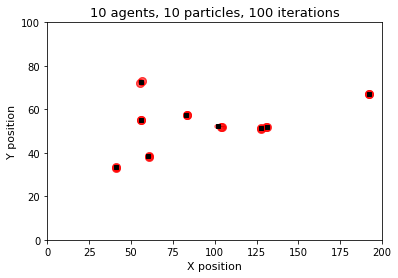

In [5]:
pf.animation[0]

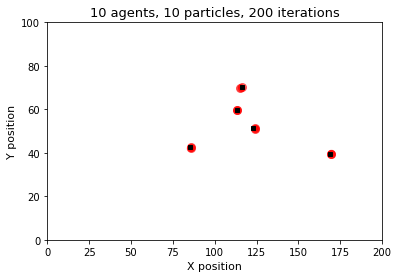

In [6]:
pf.animation[1]

If we want to re-save the images (don't necessarily want to do this if I was happy with the preivous ones they vary slightly each time the model runs.

In [34]:
#pf.animation[0].savefig("figs_for_pf_paper/ani-10agents-10particles-window100.pdf", bbox_inches="tight")

#pf.animation[1].savefig("figs_for_pf_paper/ani-10agents-10particles-window200.pdf", bbox_inches="tight")

#### 40 agents, 10 particles, First three windows

With 50 agents and still only 10 particles we start to see some agents being very poorly simulated. There are examples of XXXX (no particles correctly simulating an agent)

In [7]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

N = 40
NP = 10
model_params['pop_total'] = N
filter_params['number_of_particles'] = NP
filter_params['agents_to_visualise'] = N
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step() # Run the particle filter

# For some reason the pool doesn't always kill it's child processes (notebook problem?)
pf.pool.close() 

# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running filter with 10 particles and 1 runs (on 16 cores) with 40 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 2.66s)
	Finished window 2, step 200 (took 1.73s)
	Finished window 3, step 300 (took 0.79s)
	Finished window 4, step 400 (took 0.42s)
	Finished window 5, step 500 (took 0.21s)
	Finished window 6, step 600 (took 0.17s)
	Finished window 7, step 700 (took 0.12s)
	Finished window 8, step 800 (took 0.11s)
	Finished window 9, step 900 (took 0.03s)


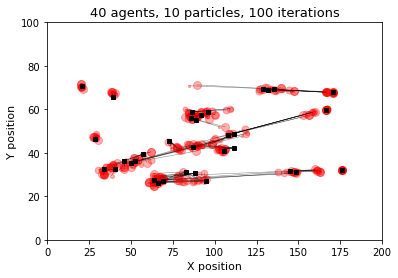

In [8]:
pf.animation[0]

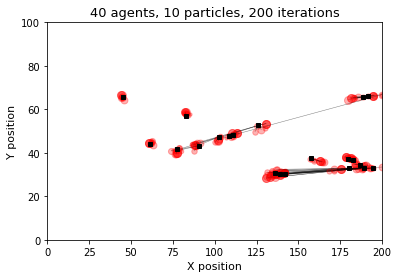

In [9]:
pf.animation[1]

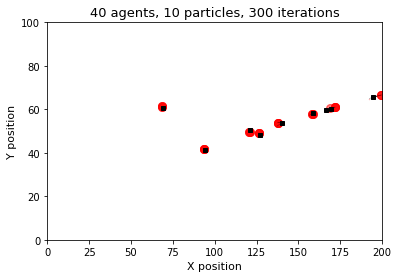

In [10]:
pf.animation[2]

If we want to re-save the images the uncomment below (don't necessarily want to do this if I was happy with the preivous ones they vary slightly each time the model runs).

In [33]:
#pf.animation[0].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window100.pdf", bbox_inches="tight")
#pf.animation[1].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window200.pdf", bbox_inches="tight")
#pf.animation[2].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window300.pdf", bbox_inches="tight")

#### For AAMAS: First window with 10, 15, 20, and 40 agents


In [33]:

# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

pfs = [] # An array of paticle filters (one for each number of agents)
filter_params['number_of_particles'] = 10

# Loop over the number of agents
for n in [5, 10, 20, 40]:
    print(f"Running with {n} agents...")
    model_params['pop_total'] = n
    filter_params['agents_to_visualise'] = n
    pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
    pf.step() # Run the particle filter
    pf.pool.close() 
    #pfs.append(pf)
    pf.animation[0]
    pf.animation[0].savefig(f"figs_for_pf_paper/ani-AAMAS-{n}agents-{10}particles-window100.pdf", bbox_inches="tight")


# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running with 5 agents...
Running filter with 10 particles and 1 runs (on 16 cores) with 5 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 0.31s)
	Finished window 2, step 200 (took 0.19s)
	Finished window 3, step 300 (took 0.06s)
Running with 10 agents...
Running filter with 10 particles and 1 runs (on 16 cores) with 10 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 0.84s)
	Finished window 2, step 200 (took 0.29s)
	Finished window 3, step 300 (took 0.03s)
Running with 20 agents...
Running filter with 10 particles and 1 runs (on 16 cores) with 20 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 1.26s)
	Finished window 2, step 200 (took 0.58s)
	Finished window 3, step 300 (took 0.26s)
	Finished window 4, step 400 (took 0.12s)
	Finished window 5, step 500 (took 0.11s)
	Finished window 6, step 600 (took 0.04s)
Running with 40 agents...
Running filter with 10 particles and 1 runs

#### For ECAI - One run with 20 agents and 10 particles

In [16]:

# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

pfs = [] # An array of paticle filters (one for each number of agents)
filter_params['number_of_particles'] = 10
model_params['pop_total'] = 20
filter_params['agents_to_visualise'] = 20

pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
pf.step() # Run the particle filter
pf.pool.close() 
    #pfs.append(pf)
pf.animation[0]
pf.animation[0].savefig(f"figs_for_pf_paper/ani-ECAI-{10}agents-{10}particles-window100.pdf", bbox_inches="tight")


# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running filter with 10 particles and 1 runs (on 12 cores) with 20 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 1.04s)
	Finished window 2, step 200 (took 0.43s)
	Finished window 3, step 300 (took 0.23s)
	Finished window 4, step 400 (took 0.21s)
	Finished window 5, step 500 (took 0.19s)
	Finished window 6, step 600 (took 0.16s)
	Finished window 7, step 700 (took 0.26s)
	Finished window 8, step 800 (took 0.12s)
	Finished window 9, step 900 (took 0.09s)
	Finished window 10, step 1000 (took 0.09s)
	Finished window 11, step 1100 (took 0.08s)
	Finished window 12, step 1200 (took 0.09s)
	Finished window 13, step 1300 (took 0.08s)
	Finished window 14, step 1400 (took 0.02s)


## Particle Variance

Good particle variance is important. Low variance might indicate that the particles have all converged onto a single point. 

XXXX HERE Make three graphs to show how the error and variance are related to the number of particles.
Will need to run the experiment N (10?) times for each graph and do a scatter plot to show how mean and variance vary across a few runs.
Also will need to edit pf code to extract the error and variance at each window (currently only statistics across a whole run are reported).

Graph 1:

 - show how error and variance change for one run with **5 agents and 10(?) particles**.
 - will have low variance and low error: the low variance doesn't matter because it's easy for the PF to simulate the system with only a few agents

Graph 2: 

 - show how error and variance change for one run with **30 agents and 100(?) particles**.
 - will have low variance, but high error because none of the particles are doing well

Graph 3:

 - show how error and variance change for one run with **30 agents and 10,000(?) particles**.
 - will have high variance because large number of particles and low error because some particles are able to simulate well.

Set up the experiments:

In [9]:
N=30 # Number of runs for each experiment

def run_variance_experiment(pop, particles, num_runs=10):
    model_params['pop_total'] = pop
    filter_params['number_of_particles'] = particles
    filter_params['do_ani'] = False
    variances = []
    errors = []
    windows = []
    
    for i in range(num_runs):
        print(f"\n ********** Starting Experiment {i+1}/{num_runs} **********")
        pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()/2))
        result = pf.step() # Run the particle filter
        # Get the variances and errors *after* resampling
        assert(len(pf.variances)==len(pf.mean_errors))
        variances = variances + [ pf.variances[j]   for j in range(len(pf.variances))   if not pf.before_resample[j] ]
        errors = errors +       [ pf.mean_errors[j] for j in range(len(pf.mean_errors)) if not pf.before_resample[j] ]
        assert(len(variances)==len(errors))
        # The number of windows varies for each run
        windows = windows + list(range(1, len([x for x in pf.before_resample if x==True]) +1 ) )
        assert(len(windows)==len(variances))
        pf.pool.close() # For some reason the pool doesn't always kill it's child processes (notebook problem?)
        
    print("********** Finished Experiments **********")
    return pd.DataFrame(list(zip(windows, errors, variances)), columns=["Window", "Error", "Variance"])

### Variance: Run the experiments.

This takes ages, especially for the more complicated experiment (3), so load cached results if available.

In [3]:
# Prepare for caching
fname = os.path.join("./pickles","variance_results.pickle")
results1 = None
results1_melt = None
results2 = None
results2_melt = None
results3 = None
results3_melt = None

# Load from disk:
if os.path.isfile(fname):
    print(f"Loading results from pickle file: {fname}")
    with open(fname, 'rb') as f:
        results1 = pickle.load(f)
        results1_melt = pickle.load(f)
        results2 = pickle.load(f)
        results2_melt = pickle.load(f)
        results3 = pickle.load(f)
        results3_melt = pickle.load(f)
# Otherwise re-run (this will take some time)
else:
    print("Running experiments, this will take some time.")

    # Experiment 1: 5 agents, 10 particles
    results1 = run_variance_experiment(pop=5, particles=10, num_runs=N)
    # Also melt the results for the boxplots coming shortly
    results1_melt = pd.melt(results1, id_vars=['Window'], value_vars=['Error','Variance'])

    # Experiment 2: 30 agents, 10 particles
    results2 = run_variance_experiment(pop=30, particles=10, num_runs=N)
    results2_melt = pd.melt(results2, id_vars=['Window'], value_vars=['Error','Variance'])
    
    # Experiment 3: 30 agents, 5,000 particles
    results3 = run_variance_experiment(pop=30, particles=5000, num_runs=N)
    results3_melt = pd.melt(results3, id_vars=['Window'], value_vars=['Error','Variance'])
    
    print(f"Finished running experiments. Writing experiments to pickle file: {fname}")
    with open(fname, 'wb') as f:
        pickle.dump(results1, f)
        pickle.dump(results1_melt, f)
        pickle.dump(results2, f)
        pickle.dump(results2_melt, f)
        pickle.dump(results3, f)
        pickle.dump(results3_melt, f)

Loading results from pickle file: ./pickles/variance_results.pickle


### Variance: results

Graph the results of those three experiments together

/Users/nick/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/nick/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


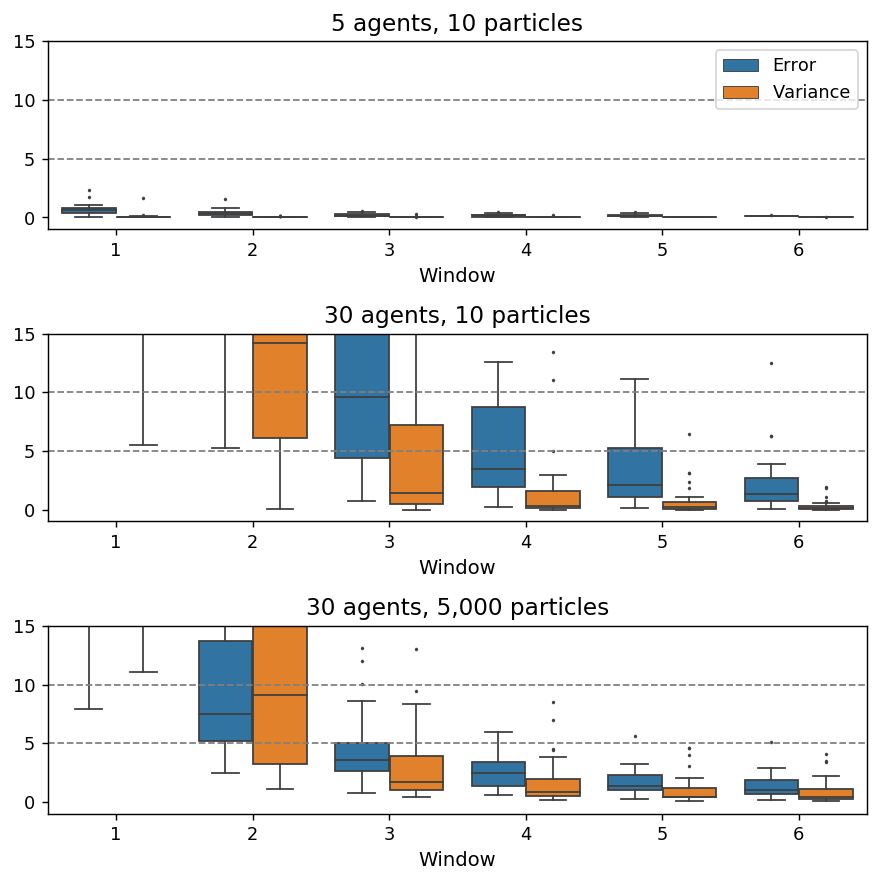

In [5]:
#plt.tight_layout()
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(7, 7), dpi=128, facecolor='w', edgecolor='k')
fig.set_tight_layout(True)

for i, (axis, results, title) in enumerate([ \
                             (ax1, results1_melt, "5 agents, 10 particles"),\
                             (ax2, results2_melt, "30 agents, 10 particles"),\
                             (ax3, results3_melt, "30 agents, 10,000 particles")]):

    sns.boxplot(ax=axis, x="Window", y="value", hue="variable", data=results, linewidth=1, fliersize=1)
    axis.set_ylim(-1,15)
    axis.set_xlim(-0.5,5.5)
    axis.title.set_text(title)
    axis.set_ylabel("")
    for j in [5,10]: # Draw some horizontal lines for easy interpretation
        axis.axhline(y=j,linewidth=1, linestyle="dashed", color="grey")
    # Overide the default seaborn legend (https://stackoverflow.com/questions/35538882/seaborn-boxplot-stripplot-duplicate-legend)
    handles, labels = axis.get_legend_handles_labels() # Get the handles and labels.
    if i==0: # Make a legend on the first plot, but not on the others
        axis.legend(handles, labels, loc="upper right")
    else:
        axis.legend().set_visible(False)
    

fig.savefig("figs_for_pf_paper/variance_results.png", bbox_inches="tight")

## Impact of Resampling

Plots that show how resampling reduced the error of the population of particles

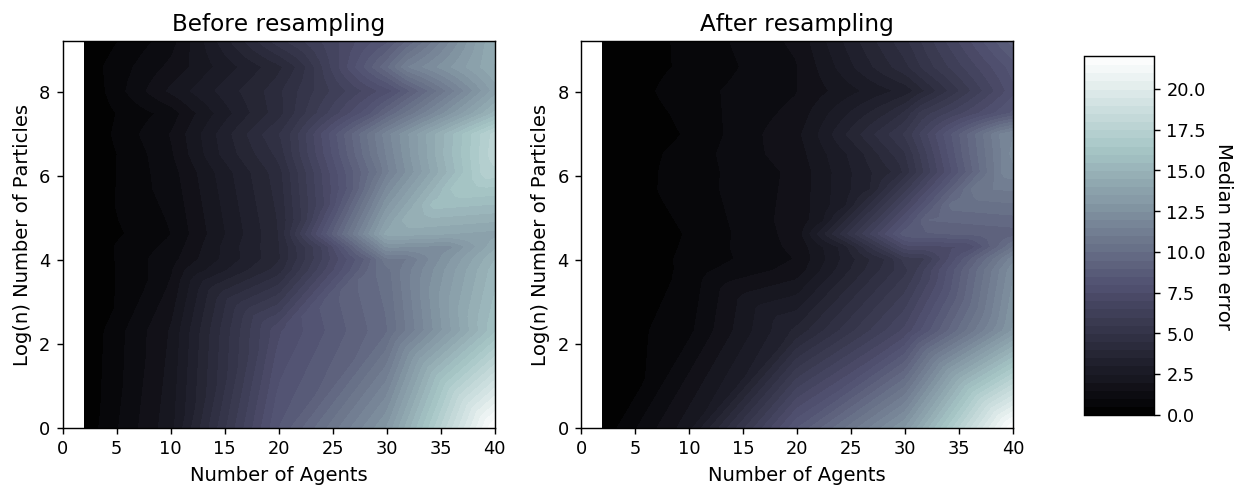

In [33]:
# Title and array
#title = "Median absolute error"
title = "Median mean error"
d0 = plot_def[title][0] # Index 1 for the array created *beforer* resampling
d1 = plot_def[title][1] # Index 1 for the array created *after* resampling

# Calculate the value of the error statistic as a long list
z0 = make_z(d0)
z1 = make_z(d1)

# Turn that into a grid
zi0 = make_zi(z0)
zi1 = make_zi(z1)

# Use the same colour bar for both images, so need to normalise the colours
# (use error before resampling (z0)  because it is bigger)
colours_norm = matplotlib.colors.Normalize(vmin=0,vmax=z0.max())

fig = plt.figure(num=None, figsize=(11, 4), dpi=128, facecolor='w', edgecolor='k')

ax0 = plt.subplot(121) #nrows, ncols, index,
cs0 = plt.contourf(xi,yi,zi0,levels=num_colours,cmap=colour_map, norm=colours_norm)
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
#plt.ylim(2,9)
plt.title(f"Before resampling")

ax1 = plt.subplot(122) #nrows, ncols, index,
cs1 = plt.contourf(xi,yi,zi1,levels=num_colours,cmap=colour_map, norm=colours_norm)
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
#plt.ylim(2,9)
plt.title(f"After resampling")

# Add the colour bar (https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cs0, cax=cbar_ax)
# Give the colour bar a label https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels#15913419
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(title, rotation=270)

#plt.show()
plt.savefig("figs_for_pf_paper/resampling.png", bbox_inches="tight")
del(colours_norm) # cleaning up

## Benchmarking: What happens with no resampling?

What happens if we turn resampling off all together?

### Visualising 10 agents & 10 particles with no benchmarking

There's not a huge difference, but some of the agent positions do drift a little

In [4]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

# Turn off resampling
filter_params['do_resample'] = False


N = 10
NP = 10
model_params['pop_total'] = N
filter_params['number_of_particles'] = NP
filter_params['agents_to_visualise'] = N
filter_params['do_ani'] = True
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step() # Run the particle filter

# For some reason the pool doesn't always kill it's child processes (notebook problem?)
pf.pool.close() 

# Turn on inline plotting again
%matplotlib inline



Using matplotlib backend: MacOSX
**Warning**: Not resampling. This should only be used for benchmarking
Running filter with 10 particles and 1 runs (on 16 cores) with 10 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 0.86s)
	Finished window 2, step 200 (took 0.4s)
	Finished window 3, step 300 (took 0.18s)
	Finished window 4, step 400 (took 0.03s)


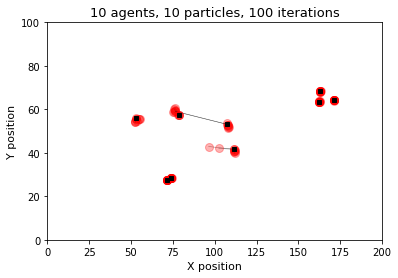

In [8]:
pf.animation[0]
#pf.animation[0].savefig("figs_for_pf_paper/benchmarking-agent_locations.png", bbox_inches="tight")

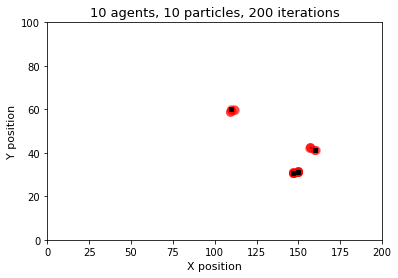

In [6]:
pf.animation[1]

### Overall benchmarking error

Firstly check that, with no resampling, the number of particles does not influence the overall error. Then see how the errors vary with the number of agents

For info, the results object from the particle filter is an array with two dimensions (one before and one after resampling) with the following values:

 - 0: `min(np.array(self.mean_errors)`:             Minimum mean distance between weighted mean state and the true state
 - 1: `max(np.array(self.mean_errors)`:             Maximum ^^
 - 2: `np.average(np.array(self.mean_errors)`:      Mean ^^
 - 3: `min(np.array(self.absolute_errors)`:         Minimum unweighted distance between mean state and the true state
 - 4: `max(np.array(self.absolute_errors)`:         Maximum ^^
 - 5: `np.average(np.array(self.absolute_errors)`:  Mean ^^
 - 6: `min(np.array(self.variances)`:               Minimum variance
 - 7: `max(np.array(self.variances)`:               Maximum ^^
 - 8: `np.average(np.array(self.variances)`:        Mean ^^

#### (Check particle number does not affect error)

Make sure that changing the number of particles doesn't have an influence on the average error and also sanity check that the results before and after benchmarking are comparible

In [11]:
filter_params['do_resample'] = False
filter_params['do_ani'] = False

# Prepare for caching
fname = os.path.join("./pickles","benchmark-num_particles.pickle")

num_runs = 20
particle_experiments= [10, 100, 1000, 5000] # How many particles to use
N = 20
results = []

# Load from disk:
if os.path.isfile(fname):
    print(f"Loading results from pickle file: {fname}")
    with open(fname, 'rb') as f:
        results = pickle.load(f)
        
else: # Otherwise re-run (this will take some time)
    print("Running benchmarking experiments, this will take some time.")
    for num_particles in particle_experiments:
        for run in range(num_runs):
            model_params['pop_total'] = N
            filter_params['number_of_particles'] = num_particles
            pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
            results.append(pf.step()) # Run the particle filter and append results to the array
            pf.pool.close() # In case the pool didn't close properly

    print(f"Finished running experiments. Writing experiments to pickle file: {fname}")
    with open(fname, 'wb') as f:
        pickle.dump(results, f)


Loading results from pickle file: ./pickles/benchmark-num_particles.pickle


Firstly check that there are no differences before or after benchmarking

In [ ]:
print("Mean error before, mean error after, mean variance before, mean variance after")
for r in results:
    print(f"{r[0][2]},{r[1][2]},{r[0][8]},{r[1][8]} ")

Now have a look to see what difference the number of particles makes. _No need to do visualisations as this is mostly for sanity checking, can copy the output to a csv file and load in excel to see averages).

In [ ]:
print("Partcies, Mean error before, mean error after, mean variance before, mean variance after")

counter = 0 # index into the array of results
for num_particles in particle_experiments:
    for j in range(num_runs):
        r = results[counter]
        print(f"{num_particles}, {r[0][2]},{r[1][2]},{r[0][8]},{r[1][8]} ")
        counter+=1

#### Error without resampling

Create table showing error as number of agents increases. Use 1000 particles (this is arbitrary because the number of particles doesn't influence the mean error).

In [57]:
filter_params['do_resample'] = False
filter_params['do_ani'] = False

# Prepare for caching
fname = os.path.join("./pickles","benchmark-num_agents.pickle")

num_runs = 10
agents_experiments= list(range(2, 42, 2)) # Number of agents per experiment 
filter_params['number_of_particles'] = 1000
results = []

# Load from disk:
if os.path.isfile(fname):
    print(f"Loading results from pickle file: {fname}")
    with open(fname, 'rb') as f:
        results = pickle.load(f)
else: # Otherwise re-run (this will take some time)
    print("Running benchmarking experiments, this will take some time.")
    for num_agents in agents_experiments:
        model_params['pop_total'] = num_agents
        print(f"\n*************** EXPERIMENT WITH {num_agents} AGENTS ***************")
        for run in range(num_runs):
            pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()/2))
            results.append(pf.step()) # Run the particle filter and append results to the array
            pf.pool.close() # In case the pool didn't close properly

    print(f"Finished running experiments. Writing experiments to pickle file: {fname}")
    with open(fname, 'wb') as f:
        pickle.dump(results, f)

Loading results from pickle file: ./pickles/benchmark-num_agents.pickle


Recall the results from earlier (i.e. with resampling) (these were the 'median mean error'). These will be added to the plot below

In [100]:
headline_results

,2 agents,10 agents,20 agents,30 agents,40 agents
1 particles,0.138211,2.312128,8.497060,13.011408,22.023209
10 particles,0.068356,0.873291,3.656614,7.143396,13.103061
50 particles,0.080182,0.589456,1.495473,5.134477,12.310097
100 particles,0.086503,0.529954,1.705605,8.837322,9.198673
500 particles,0.056892,0.737416,1.626804,4.306741,11.982007
1000 particles,0.044444,0.545280,1.925523,5.729030,12.518787
2000 particles,0.047532,0.651315,1.627600,4.394098,7.862144
3000 particles,0.024394,0.816647,1.470197,3.129751,7.806832
5000 particles,0.037118,0.583427,1.424145,4.296108,8.060279
7500 particles,0.022669,0.703281,1.633475,4.540174,9.009156


Plot of the error with number of agents and also add the error with resampling

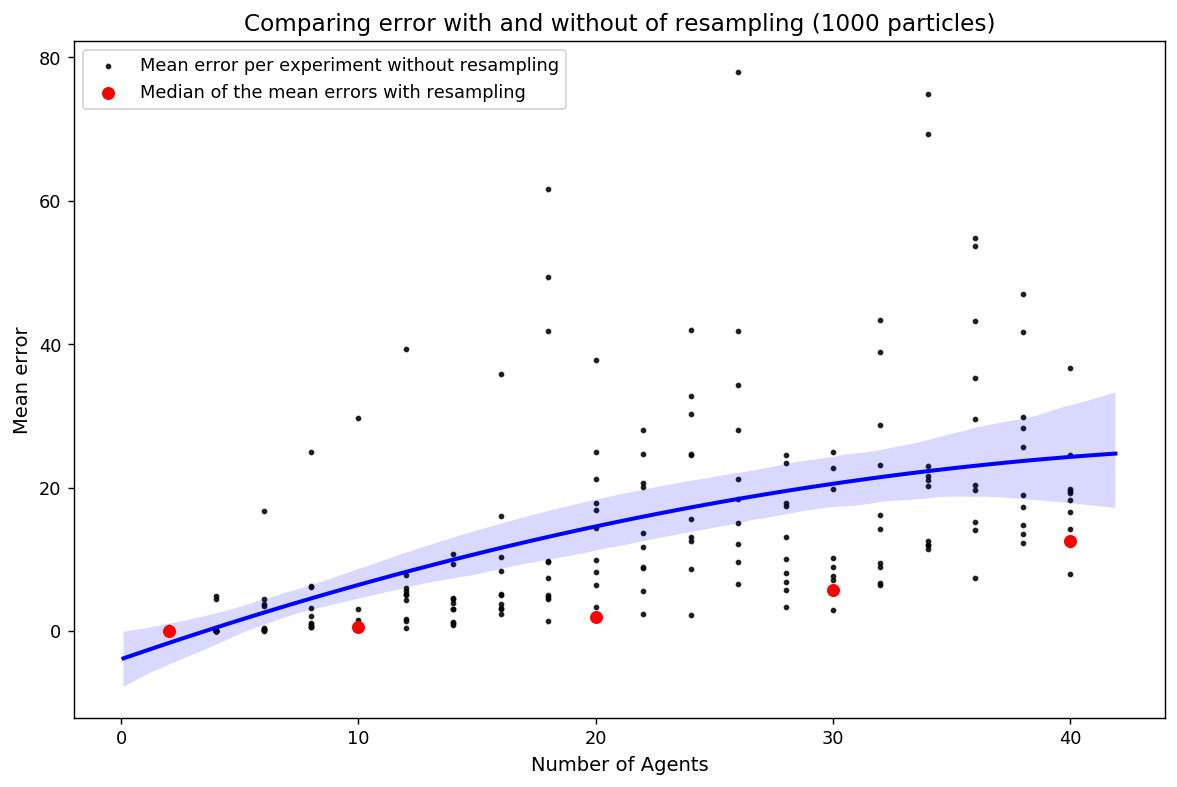

In [122]:
# Make arrays of the x and y values for a scatter plot
agents = [] # (x values)
for i in agents_experiments:
    for j in range(num_runs):
        agents.append(i)

errors = [] # (y values)
for result in results:
    errors = errors + [result[1][2]] # The mean error (index 2) after resampling (index 1)

assert len(errors) == len(agents)

# Create a figure and an axis
fig, ax = plt.subplots(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')

# Use seaborn to add a plot to the axis
p = sns.regplot(ax=ax, x=agents, y=errors, 
                 order = 2, ci=99,
                 scatter_kws={"color":"black", "s":5}, 
                 line_kws={"color":"blue"},
                 label="Mean error per experiment without resampling")
ax.set_title("Comparing error with and without of resampling (1000 particles)")
ax.set_xlabel("Number of Agents")
ax.set_ylabel("Mean error")

ax.scatter(x=[2, 10, 20, 30, 40], y=headline_results.loc[ ["1000 particles"],:].T.values.tolist(), 
              s=40, c="red", label="Median of the mean errors with resampling")
    
    
ax.legend(loc='upper left')

plt.savefig("figs_for_pf_paper/benchmark-agents_vs_error.png", bbox_inches="tight")

Make a table showing the median benchmark error (without resampling) and the median error with resampling (from earlier).



These are the errors with 1000 particles:

In [46]:
headline_results.loc[ ["1000 particles"],:]

,2 agents,10 agents,20 agents,30 agents,40 agents
1000 particles,0.044444,0.54528,1.925523,5.72903,12.518787


Now get the median errors for the numbers of agents without resampling

In [69]:
median_errors = []
for a in [2, 10, 20, 30, 40]: # These are the numbers of agents we're interested in 
    first_index = agents.index(a)
    print(first_index)
    errors_per_agent = []
    for i in range(first_index, first_index+num_runs):
        errors_per_agent.append(errors[i])
    assert len(errors_per_agent) == num_runs
    median_errors.append(np.median(errors_per_agent))
assert len(median_errors) == 5

0
40
90
140
190


So here is a table comparing those numbers of agents with and without 

### Impact of Noise

Plots that show the impact of changing the amount of particle noise from $\sigma_p=0.25$ to $\sigma_p=0.5$

_Sorry, this is disgusging. To plot the more noisy scenarios we need to re-read the data stored in a different directory (`noise2`) so I've just copied data reading the code from above (without the warnings)_

In [34]:
path = os.path.join(root_dir[0], "results","4/noise0.5")
print(f"Plotting results in directory: {path}")


files = []
duplicates = [] # List of diplicate files
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            fname = os.path.join(r, file)
            if is_duplicate(fname, files):
                duplicates.append(fname)
            else:
                files.append(fname)

if len(files) == 0:
    sys.exit("Found no files in {}, can't continue".format(path) )
elif len(duplicates) > 0:
    warnings.warn("Found {} duplicate files:\n\t{}".format(len(duplicates), "\n\t".join(duplicates)))
else:
    print("Found {} files".format(len(files)))


# Errors are a matrix of particles * agents. These are a tuple because the errors
# are calculated before and after resampling

def init_matrix():
    return ( np.zeros(shape=(len(particles),len(agents))), np.zeros(shape=(len(particles),len(agents))) )

min_mean_err = init_matrix()
max_mean_err = init_matrix()
ave_mean_err = init_matrix() # Mean of the mean errors
med_mean_err = init_matrix() # Median of the mean errors
min_abs_err  = init_matrix()
max_abs_err  = init_matrix()
ave_abs_err  = init_matrix() # Mean of the mean errors
med_abs_err  = init_matrix() # Median of the mean errors
min_var      = init_matrix()
max_var      = init_matrix()
ave_var      = init_matrix()
med_var      = init_matrix()

# Regular expressions to find the particle number and population total from json-formatted info at the start of the file
particle_num_re = re.compile(r".*?'number_of_particles': (\d*).*?")
agent_num_re = re.compile(r".*?'pop_total': (\d*).*?")

print("Reading files....",)
warn_about_arrays = False
data_shape = None # Check each file has a consistent shape
for i, f in enumerate(files):

    file = open(f,"r").read()
    #data = pd.read_csv(f, header = 2).replace('on',np.nan)
    data = pd.read_csv(f, header=2).replace('on', np.nan)
    # Check that each file has a consistent shape
    # Filter by whether errors are before or after (NOW DONE LATER, THIS CAN GO)
    #data = data[ data.loc[:,'Before_resample?'] == before]

    # Find the particle number and population total from json-formatted info at the start of the file
    search = re.findall(particle_num_re, file)
    try:
        particle_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of particles in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
    search = re.findall(agent_num_re, file)
    try:
        agent_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of agents in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
    
    try: 
        # Calculate the statstics before and after resampling
        for before in [0,1]:
            d = data[ data.loc[:,'Before_resample?'] == before] # Filter data

            data_mean =  d.mean() # Calculate the mean of all columns
            data_median = d.median() # and also sometimes use median

            min_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Mean_errors']
            max_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Mean_errors']
            ave_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_mean_errors']
            med_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_mean_errors']
            min_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Absolute_errors']
            max_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Absolute_errors']
            ave_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_Absolute_errors']
            med_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_Absolute_errors']
            min_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_variances']
            max_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_variances']
            ave_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_variances']
            med_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_variances']
            
    except ValueError:
        if not warn_about_arrays:
            warnings.warn(f"Have found a file ({f}) whose number of agents ({agent_num}) and/or particles ({particle_num}) don't fit into the results arrays. Have you defined num_age and num_par correctly? (Further warnings surpressed)")
        warn_about_arrays = True
        
# There will never be zero error, so replace 0s with NA
data[data == 0] = np.nan        

print("...finished reading {} files".format(len(files)))

# Define the plots so that they can be plotted in a loop
plot_def = {
    "Min absolute error" : min_mean_err,
    "Max absolute error" : max_mean_err,
    "Avg absolute error" : ave_mean_err,
    "Median mean error":  med_mean_err,
    "Min absolute error"  : min_abs_err,
    "Max absolute error"  : max_abs_err,
    "Avg absolute error"  : ave_abs_err,
    "Median absolute error": med_abs_err,
    "Min variance"   : min_var,
    "Max variance"   : max_var,
    "Avg variance"  : ave_var,
    "Median variance"  : med_var
    }

Plotting results in directory: /Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.5
Found 66 files
Reading files....


/Users/nick/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Have found a file (/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/4/noise0.5/pf_particles_7500_agents_50_noise_0.5-1567847830.csv) whose number of agents (50) and/or particles (7500) don't fit into the results arrays. Have you defined num_age and num_par correctly? (Further warnings surpressed)


...finished reading 66 files


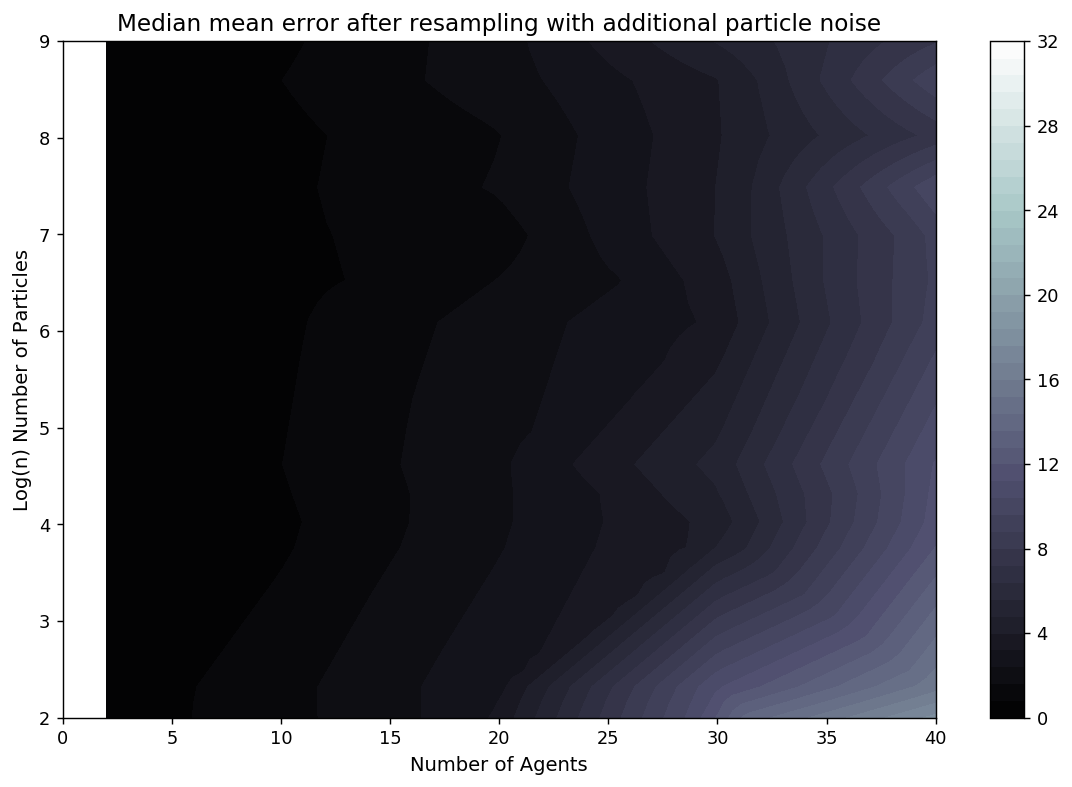

In [37]:
#title = "Median absolute error"
title = "Median mean error"
d = plot_def[title][1] # Index 1 for the array created *after* resampling

# Calculate the value of the error statistic as a long list
z = make_z(d)

# Turn that into a grid
zi = make_zi(z)

fig = plt.figure(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
#cs1 = plt.contour( xi,yi,zi,levels=num_colours,linewidths=0.5,colors='k')
cs2 = plt.contourf(xi,yi,zi,levels=num_colours,cmap=colour_map)
plt.colorbar() # draw colorbar
#plt.scatter(x,y,marker='o',c=z, cmap=cs2.get_cmap(), s=5)
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
plt.ylim(2,9)
plt.title(title+" after resampling with additional particle noise")
plt.savefig("figs_for_pf_paper/median_abs_error-noise2_0.png", bbox_inches="tight")
del(z, d, zi) # tidy up